In [1]:
#Using Cryptocompare Free API which has historical data for over 90 exchanges, 1800 coins/tokens - 
#CCCAGG is the weighted average price of all exchanges tracked 
#More information - (https://www.cryptocompare.com/coins/guides/how-does-our-cryptocurrecy-index-work/)
#2000 limit of rows

from_symbol = 'BTC'
to_symbol = 'USD'

exchange = 'CCCAGG'
#Intervals supported minute, hour and day
datetime_interval = 'day'

In [2]:
import pandas as pd
import requests
from datetime import datetime

In [3]:
#Functions to automate naming and saving of csv files from API

def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    #Use aggregate to group different periods of time
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)


Filtering 0 empty datapoints
Saving data to BTC_USD_CCCAGG_day_2018-03-24.csv


In [5]:
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)


Reading data from BTC_USD_CCCAGG_day_2018-03-24.csv
(2001, 6)


In [6]:
df.head()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2012-10-01,12.32,12.48,12.40,12.40,24826.69,307618.78
2012-10-02,12.34,12.88,12.40,12.84,50833.35,642027.91
2012-10-03,12.68,12.99,12.84,12.89,32955.07,422995.61
2012-10-04,12.60,13.09,12.89,12.85,37945.15,488811.23
2012-10-05,12.51,12.97,12.85,12.69,31258.44,398427.10


In [7]:
df.tail()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2018-03-20,8339.80,9056.23,8623.14,8920.71,131959.66,1.150462e+09
2018-03-21,8778.69,9184.51,8920.53,8911.35,109985.22,9.913764e+08
2018-03-22,8500.88,9107.00,8911.37,8724.98,116522.98,1.023287e+09
2018-03-23,8307.58,8935.88,8724.98,8934.80,109649.39,9.399973e+08
2018-03-24,8694.82,8991.76,8935.51,8985.84,49754.04,4.431484e+08


In [8]:
df.describe()

,low,high,open,close,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,1383.915722,1512.409225,1452.896627,1457.383538,60880.681639,1.649593e+08
std,2783.791504,3104.212115,2964.391313,2968.985758,59787.304927,4.776074e+08
min,9.740000,10.650000,10.170000,10.170000,404.380000,1.094799e+05
25%,230.580000,238.950000,235.030000,235.200000,21524.090000,3.721815e+06
50%,428.840000,450.800000,440.060000,441.110000,44441.440000,1.515475e+07
75%,825.040000,905.700000,872.030000,879.900000,82207.990000,4.580598e+07
max,18750.910000,19870.620000,19346.600000,19345.490000,572349.320000,6.245732e+09


In [9]:
import talib as ta
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')

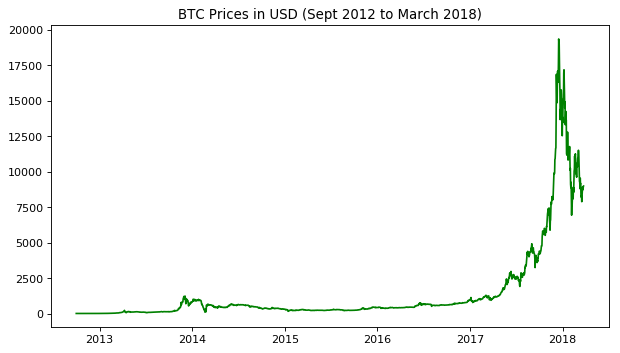

In [10]:
plt.plot(df.close, color='g')
plt.title('BTC Prices in USD (Sept 2012 to March 2018)')
plt.show()

In [11]:
#Shift price 7 days behind 
df['targetprice'] = df['close'].shift(-7)

#Using technical analysis library to create common technical indicators

#Common Technical Analysis Indicators
df['SMA'] = ta.SMA(df.close)
df['AD'] = ta.AD(df.high,df.low,df.close,df.volumefrom)
df['ADOSC'] = ta.ADOSC(df.high,df.low,df.close,df.volumefrom)
df['ADX'] = ta.ADX(df.high,df.low,df.close)
df['ADXR'] = ta.ADXR(df.high,df.low,df.close)
df['APO'] = ta.APO(df.close)
df['AROONOSC'] = ta.AROONOSC(df.high,df.low)
df['ATR'] = ta.ATR(df.high,df.low,df.close)
df['BOP'] = ta.BOP(df.open,df.high,df.low,df.close)
df['CCI'] = ta.CCI(df.high,df.low,df.close)
df['CMO'] = ta.CMO(df.close)
df['DEMA'] = ta.DEMA(df.close)
df['DX'] = ta.DX(df.high,df.low,df.close)
df['EMA'] = ta.EMA(df.close)
df['HT_TRENDMODE'] = ta.HT_TRENDMODE(df.close)
df['HT_TRENDLINE'] = ta.HT_TRENDLINE(df.close)
df['KAMA'] = ta.KAMA(df.close)
df['MA'] = ta.MA(df.close)
df['MFI'] = ta.MFI(df.high,df.low,df.close,df.volumefrom)
df['MINUS_DI'] = ta.MINUS_DI(df.high,df.low,df.close)
df['MINUS_DM'] = ta.MINUS_DM(df.high,df.low)
df['MOM'] = ta.MOM(df.close)
df['OBV'] = ta.OBV(df.close,df.volumefrom)
df['PLUS_DI'] = ta.PLUS_DI(df.high,df.low,df.close)
df['PLUS_DM'] = ta.PLUS_DM(df.high,df.low)
df['PPO'] = ta.PPO(df.close)
df['ROCP'] = ta.ROCP(df.close)
df['RSI'] = ta.RSI(df.close)
df['SAR'] = ta.SAR(df.high,df.low)
df['SAREXT'] = ta.SAREXT(df.high,df.low)
df['SMA'] = ta.SMA(df.close)
df['T3'] = ta.T3(df.close)
df['TEMA'] = ta.TEMA(df.close)
df['TRANGE'] = ta.TRANGE(df.high,df.low,df.close)
df['TRIX'] = ta.TRIX(df.close)
df['ULTOSC'] = ta.ULTOSC(df.high,df.low,df.close)
df['WILLR'] = ta.WILLR(df.high,df.low,df.close)
df['WMA'] = ta.WMA(df.close)

#Candlestick indicators
df['CDL2CROWS'] = ta.CDL2CROWS(df.open,df.high,df.low,df.close)
df['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(df.open,df.high,df.low,df.close)
df['CDL3INSIDE'] = ta.CDL3INSIDE(df.open,df.high,df.low,df.close)
df['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(df.open,df.high,df.low,df.close)
df['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(df.open,df.high,df.low,df.close)
df['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(df.open,df.high,df.low,df.close)
df['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(df.open,df.high,df.low,df.close)
df['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(df.open,df.high,df.low,df.close)
df['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(df.open,df.high,df.low,df.close)
df['CDLBELTHOLD'] = ta.CDLBELTHOLD(df.open,df.high,df.low,df.close)
df['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(df.open,df.high,df.low,df.close)
df['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(df.open,df.high,df.low,df.close)
df['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(df.open,df.high,df.low,df.close)
df['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(df.open,df.high,df.low,df.close)
df['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(df.open,df.high,df.low,df.close)
df['CDLDOJI'] = ta.CDLDOJI(df.open,df.high,df.low,df.close)
df['CDLDOJISTAR'] = ta.CDLDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(df.open,df.high,df.low,df.close)
df['CDLENGULFING'] = ta.CDLENGULFING(df.open,df.high,df.low,df.close)
df['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(df.open,df.high,df.low,df.close)
df['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(df.open,df.high,df.low,df.close)
df['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(df.open,df.high,df.low,df.close)
df['CDLHAMMER'] = ta.CDLHAMMER(df.open,df.high,df.low,df.close)
df['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(df.open,df.high,df.low,df.close)
df['CDLHARAMI'] = ta.CDLHARAMI(df.open,df.high,df.low,df.close)
df['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(df.open,df.high,df.low,df.close)
df['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(df.open,df.high,df.low,df.close)
df['CDLHIKKAKE'] = ta.CDLHIKKAKE(df.open,df.high,df.low,df.close)
df['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(df.open,df.high,df.low,df.close)
df['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(df.open,df.high,df.low,df.close)
df['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(df.open,df.high,df.low,df.close)
df['CDLINNECK'] = ta.CDLINNECK(df.open,df.high,df.low,df.close)
df['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(df.open,df.high,df.low,df.close)
df['CDLKICKING'] = ta.CDLKICKING(df.open,df.high,df.low,df.close)
df['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(df.open,df.high,df.low,df.close)
df['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(df.open,df.high,df.low,df.close)
df['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(df.open,df.high,df.low,df.close)
df['CDLLONGLINE'] = ta.CDLLONGLINE(df.open,df.high,df.low,df.close)
df['CDLMARUBOZU'] = ta.CDLMARUBOZU(df.open,df.high,df.low,df.close)
df['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(df.open,df.high,df.low,df.close)
df['CDLMATHOLD'] = ta.CDLMATHOLD(df.open,df.high,df.low,df.close)
df['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(df.open,df.high,df.low,df.close)
df['CDLONNECK'] = ta.CDLONNECK(df.open,df.high,df.low,df.close)
df['CDLPIERCING'] = ta.CDLPIERCING(df.open,df.high,df.low,df.close)
df['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(df.open,df.high,df.low,df.close)
df['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(df.open,df.high,df.low,df.close)
df['CDLSEPARATINGLINES'] = ta.CDLSEPARATINGLINES(df.open,df.high,df.low,df.close)
df['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(df.open,df.high,df.low,df.close)
df['CDLSHORTLINE'] = ta.CDLSHORTLINE(df.open,df.high,df.low,df.close)
df['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(df.open,df.high,df.low,df.close)
df['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(df.open,df.high,df.low,df.close)
df['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(df.open,df.high,df.low,df.close)
df['CDLTAKURI'] = ta.CDLTAKURI(df.open,df.high,df.low,df.close)
df['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(df.open,df.high,df.low,df.close)
df['CDLTHRUSTING'] = ta.CDLTHRUSTING(df.open,df.high,df.low,df.close)
df['CDLTRISTAR'] = ta.CDLTRISTAR(df.open,df.high,df.low,df.close)
df['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(df.open,df.high,df.low,df.close)
df['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(df.open,df.high,df.low,df.close)
df['CDLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(df.open,df.high,df.low,df.close)


In [16]:
df.tail(30)

,low,high,open,close,volumefrom,volumeto,targetprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-23,9604.00,10420.67,9847.96,10175.51,139373.76,1.399448e+09,11043.12,9666.509333,1.613432e+07,-32453.468854,...,0,0,0,0,0,0,0,0,0,0
2018-02-24,9396.54,10528.00,10175.51,9705.73,125269.68,1.244484e+09,11465.36,9617.504667,1.607751e+07,-52551.602927,...,0,0,0,0,0,0,0,0,0,0
2018-02-25,9329.44,9873.79,9705.73,9610.11,82430.45,7.930932e+08,11504.42,9567.701667,1.608009e+07,-55177.536277,...,0,0,0,0,0,0,0,-100,0,0
2018-02-26,9411.82,10457.51,9610.11,10326.50,117416.47,1.181729e+09,11440.73,9529.928000,1.616808e+07,-23237.149767,...,0,100,0,0,0,0,0,0,0,0
2018-02-27,10154.24,10879.38,10326.50,10594.76,99772.39,1.060841e+09,10735.45,9490.828667,1.618953e+07,-1233.044626,...,0,0,0,0,0,0,0,0,0,0
2018-02-28,10303.14,11067.76,10594.76,10334.44,105434.79,1.126075e+09,9928.56,9460.845000,1.609273e+07,-22920.150516,...,0,0,0,0,0,0,0,0,0,0
2018-03-01,10247.56,11090.30,10334.44,10929.37,88432.44,9.524721e+08,9316.72,9488.248667,1.614739e+07,-12317.238577,...,0,100,0,0,0,0,0,0,0,0
2018-03-02,10801.45,11191.94,10929.37,11043.12,77195.49,8.529085e+08,9252.76,9515.457333,1.616574e+07,-1019.579289,...,0,0,0,0,0,0,100,100,0,0
2018-03-03,11043.12,11530.66,11043.12,11465.36,71279.36,8.122001e+08,8797.27,9593.812000,1.621793e+07,20299.315009,...,0,0,0,0,0,0,100,0,0,0


In [17]:
df = df.loc[:, (df != 0).any(axis=0)]
df.describe()

,low,high,open,close,volumefrom,volumeto,targetprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03,1994.000000,1972.000000,2.001000e+03,1992.000000,...,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,1383.915722,1512.409225,1452.896627,1457.383538,60880.681639,1.649593e+08,1462.455607,1411.701256,6.048554e+06,28514.476576,...,18.290855,5.897051,1.149425,2.198901,15.192404,0.499750,2.048976,-0.449775,-0.299850,1.849075
std,2783.791504,3104.212115,2964.391313,2968.985758,59787.304927,4.776074e+08,2972.957996,2868.004056,3.927035e+06,48059.412620,...,38.668816,40.313861,16.842748,14.668416,35.903697,9.987498,48.588060,52.486166,5.469008,13.475133
min,9.740000,10.650000,10.170000,10.170000,404.380000,1.094799e+05,10.170000,11.030667,-9.921826e+03,-148951.794029,...,0.000000,-100.000000,-100.000000,0.000000,0.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000
25%,230.580000,238.950000,235.030000,235.200000,21524.090000,3.721815e+06,235.740000,236.465250,3.820741e+06,-2078.291511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,428.840000,450.800000,440.060000,441.110000,44441.440000,1.515475e+07,441.960000,449.573667,4.064133e+06,16529.875840,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,825.040000,905.700000,872.030000,879.900000,82207.990000,4.580598e+07,885.685000,841.645417,7.964200e+06,54816.962075,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18750.910000,19870.620000,19346.600000,19345.490000,572349.320000,6.245732e+09,19345.490000,15737.841333,1.646391e+07,291297.349657,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,100.000000


In [18]:
#Delete rows with NAN
df2 = df.dropna()
df2

#Delete columns with all 0s
df2 = df2.loc[:, (df != 0).any(axis=0)]
df2


,low,high,open,close,volumefrom,volumeto,targetprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
datetime,,,,,,,,,,,,,,,,,,,,,
2012-12-28,13.34,13.65,13.42,13.42,23813.01,3.202234e+05,13.50,13.294333,5.902203e+05,21664.190854,...,100,0,0,0,0,0,0,100,0,0
2012-12-29,13.27,13.67,13.42,13.40,26149.14,3.527223e+05,13.44,13.326000,5.810681e+05,14680.267752,...,100,0,0,0,100,0,0,-100,0,0
2012-12-30,13.35,13.59,13.40,13.45,11764.20,1.582772e+05,13.45,13.355333,5.791074e+05,9864.779415,...,0,0,0,0,0,0,0,100,0,0
2012-12-31,13.37,13.56,13.45,13.51,15049.79,2.027989e+05,13.59,13.387000,5.862363e+05,9266.278569,...,0,100,0,0,0,0,0,0,0,0
2013-01-01,13.16,13.56,13.51,13.30,28406.21,3.788793e+05,13.74,13.413667,5.777144e+05,5467.546490,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,13.16,13.40,13.30,13.28,17966.81,2.391562e+05,13.77,13.433667,5.777144e+05,3416.470049,...,100,0,0,0,100,0,0,-100,0,0
2013-01-03,13.25,13.46,13.28,13.40,18032.25,2.408459e+05,14.14,13.433333,5.854425e+05,4725.748319,...,0,100,0,0,0,0,0,0,0,0
2013-01-04,13.27,13.52,13.40,13.50,29641.92,3.978843e+05,14.14,13.437333,6.103417e+05,12754.225473,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,13.31,13.55,13.50,13.44,21329.93,2.869325e+05,14.24,13.442000,6.121192e+05,15444.693773,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
import numpy as np


X = df.drop(df[['low','high','open','close','volumefrom','volumeto','targetprice']], axis = 1)
#Drop out NAN
X = X.dropna()
#Drop last row
X = X[:-7]

In [24]:
# This creates a LinearRegression object
lm = LinearRegression()
lm.fit(X,df2.targetprice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]


,features,estimatedCoefficients
0,SMA,-0.851305
1,AD,0.000172
2,ADOSC,0.000433
3,ADX,2.842095
4,ADXR,-0.403480
5,APO,1.527952
6,AROONOSC,0.095459
7,ATR,4.326558
8,BOP,-44.631131
9,CCI,-0.045901


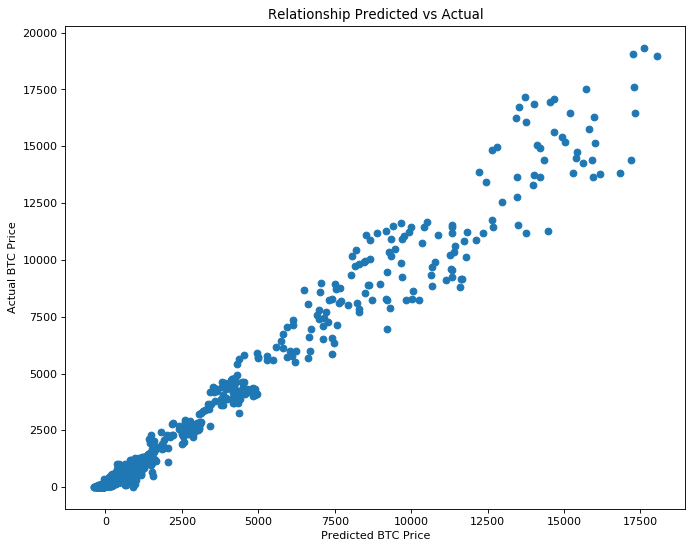

In [34]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(lm.predict(X), df2.targetprice)
plt.xlabel("Predicted BTC Price")
plt.ylabel("Actual BTC Price")
plt.title("Relationship Predicted vs Actual")
plt.show()

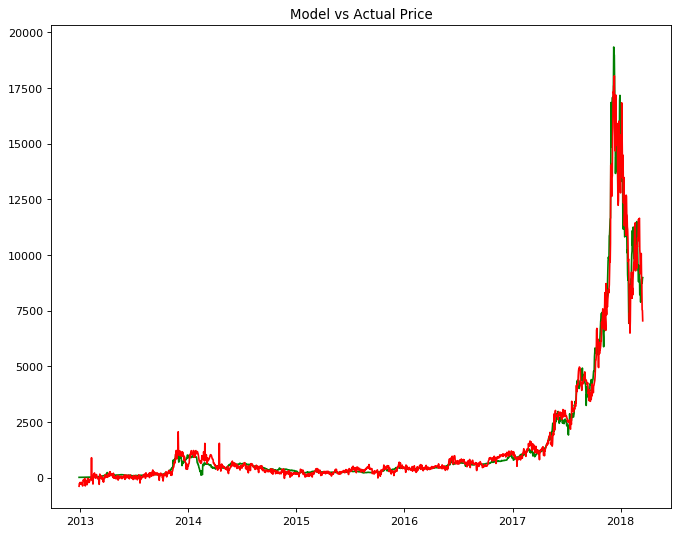

R-Squared score: 0.978


In [35]:
#Line Graph
df3 = df2
df3['predictedmodel LM'] = lm.predict(X)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(df3.targetprice, color='g')
plt.plot(df3['predictedmodel LM'], color='r')
plt.title("Model vs Actual Price")
plt.show()
print('R-Squared score: {:.3f}'.format(lm.score(X,df2.targetprice)))


In [36]:
#Hypertuning Ridge Regression

#Time Series cross-validator
#Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets.
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import Ridge
tscv = TimeSeriesSplit(n_splits=5)

# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=tscv)
grid.fit(X, df2.targetprice)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
-7.12674233852
1.0


In [38]:
#Ridge regression - best estimator alpha = 1

from sklearn.linear_model import Ridge
#Alpha is the parameter penalty - regulariztion - higher # higher penalty which will reduce complexity
linridge = Ridge(alpha=1).fit(X,df2.targetprice)
#Feature normalization so alpha penalty is applied equaly for all feature variables

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff: {}'.format(linridge.coef_))
print('R-squared score: {:.3f}'.format(linridge.score(X,df2.targetprice)))
print('Number of non-zero features {:.3f}'.format(np.sum(linridge.coef_ != 0)))


df3['Ridge'] = linridge.predict(X)


ridge regression linear model intercept: -487.9641548571358
ridge regression linear model coeff: [ -8.51253613e-01   1.71756655e-04   4.33151714e-04   2.84483883e+00
  -4.04058396e-01   1.52730622e+00   9.61841773e-02   4.32612192e+00
  -4.43512515e+01  -4.60728169e-02   6.97952156e+00   6.40643801e-01
   3.19034682e-01  -5.61298517e+00   5.08933876e+01   1.94389269e-01
  -2.34962548e+00  -8.51256826e-01   4.58571215e-01   6.63483250e+00
  -1.76062307e+00   7.09075510e-03  -1.47273339e-04  -1.78885812e+01
   1.27521432e+00   2.96013716e+00   6.33803866e+01   3.48976073e+00
   6.82841009e-01   1.09538310e-01   2.20966304e+00  -7.28343268e+00
   8.99133941e-01   5.21435249e+01  -4.05258155e+00  -7.88507932e-01
   1.39572772e+01  -1.29882792e+01   1.33754901e+01  -3.80732114e-01
   1.52724359e+00   4.22155810e-01   5.25594066e-01   3.82957705e-01
  -1.35694212e+00   1.61281014e-01   1.73049493e+01  -1.43742249e+00
   3.11526301e-01   1.57628989e+00  -5.85816811e+00  -1.62289222e-02
   1.6

In [39]:
#Ridge Regression - normalizing features so alpha regularization applied uniformly
#MinMaxScaler is one of the most popular transform methods
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
linridge2 = Ridge(alpha=1).fit(X_scaled,df2.targetprice)
r2_score = linridge2.score(X_scaled,df2.targetprice)
print(r2_score)

df3['RidgeNormalized'] = linridge2.predict(X_scaled)


0.967995805934


In [40]:
#Kernel Ridge Regression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge

scaler = MinMaxScaler()

X_scaledK = scaler.fit_transform(X)
RidgeK = KernelRidge(alpha=1).fit(X_scaledK,df2.targetprice)
#kr_r2_score = KernelRidge.score(X_scaledK,df2.targetprice)
#print(kr_r2_score)

df3['KernelRidgeNormalized'] = RidgeK.predict(X_scaledK)



In [41]:
df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized']]

,targetprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized
datetime,,,,,
2012-12-28,13.50,-387.128850,-386.888608,-353.078339,-345.616096
2012-12-29,13.44,-263.580372,-263.268841,-244.763796,-227.666687
2012-12-30,13.45,-273.024848,-272.714821,-264.322705,-249.279511
2012-12-31,13.59,-219.394297,-219.215173,-310.773653,-304.281842
2013-01-01,13.74,-287.964265,-287.915529,-298.436324,-284.161164
2013-01-02,13.77,-249.565855,-249.400127,-218.432090,-189.220889
2013-01-03,14.14,-264.555190,-264.324855,-221.214469,-195.609352
2013-01-04,14.14,-212.994831,-212.744356,-110.653184,-84.967250
2013-01-05,14.24,-293.286493,-293.122368,-288.249465,-271.930571


In [42]:
#K Nearest Neighbor Hypertuned
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaledK = scaler.fit_transform(X)


tscv = TimeSeriesSplit(n_splits=5)

tuned_parameters = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10], 
                    "weights": ["distance", "uniform"], 
                    "algorithm": ["ball_tree", "kd_tree", "brute"]}

KNei = KNeighborsRegressor()

clf = GridSearchCV(KNei, tuned_parameters, cv=tscv)

clf.fit(X_scaledK, df2.targetprice)

print("Tuned K Nearest Neighbor Parameters: {}".format(clf.best_params_))



Tuned K Nearest Neighbor Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


In [43]:
#K Nearest Neighbor Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaledK = scaler.fit_transform(X)

knnreg = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='ball_tree').fit(X_scaledK,df2.targetprice)

print('R-squared test score: {}'.format(knnreg.score(X_scaledK,df2.targetprice)))

df3['KNeighbors'] = knnreg.predict(X_scaledK)


R-squared test score: 0.9633008169928288


In [44]:
# Hypertuning Tree regression
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["mse", "friedman_mse","mae"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=tscv)

# Fit it to the data
tree_cv.fit(X,df2.targetprice)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 4}
Best score is -0.5949634611895335


In [45]:
#Tree Based Regressor with hypertuning
from sklearn.tree import DecisionTreeRegressor

# Instantiate a Decision Tree regressor: tree
tree = DecisionTreeRegressor()

tree = DecisionTreeRegressor( max_features=7, min_samples_leaf=4, criterion='friedman_mse').fit(X,df2.targetprice)

print('R-squared test score: {}'.format(tree.score(X,df2.targetprice)))

df3['Tree'] = tree.predict(X)


R-squared test score: 0.9954974250449895


In [46]:
lineplot = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree']]
lineplot

,targetprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KNeighbors,Tree
datetime,,,,,,,
2012-12-28,13.50,-387.128850,-386.888608,-353.078339,-345.616096,349.408,13.495000
2012-12-29,13.44,-263.580372,-263.268841,-244.763796,-227.666687,312.616,13.495000
2012-12-30,13.45,-273.024848,-272.714821,-264.322705,-249.279511,205.272,13.495000
2012-12-31,13.59,-219.394297,-219.215173,-310.773653,-304.281842,213.447,13.495000
2013-01-01,13.74,-287.964265,-287.915529,-298.436324,-284.161164,311.814,28.697500
2013-01-02,13.77,-249.565855,-249.400127,-218.432090,-189.220889,323.874,14.042500
2013-01-03,14.14,-264.555190,-264.324855,-221.214469,-195.609352,209.305,14.042500
2013-01-04,14.14,-212.994831,-212.744356,-110.653184,-84.967250,226.697,14.042500
2013-01-05,14.24,-293.286493,-293.122368,-288.249465,-271.930571,269.473,14.380000


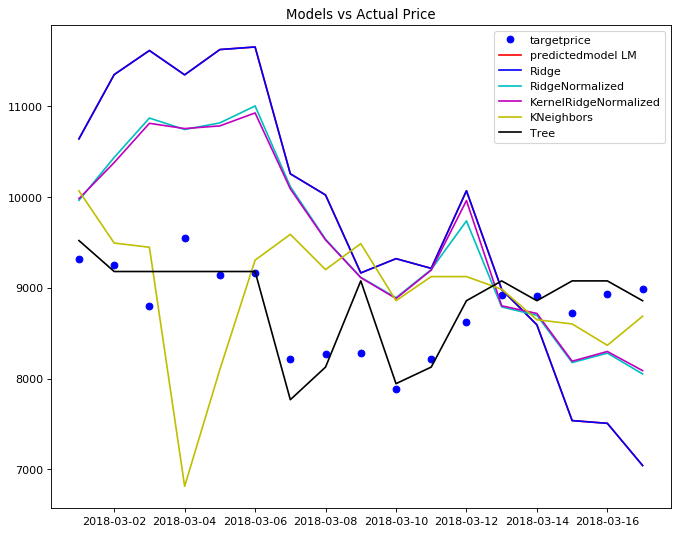

In [47]:
import matplotlib.pyplot as plt
import datetime
import math
from sklearn.metrics import mean_squared_error


fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
lineplot = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree']]
lineplot = lineplot.loc['2018-3-1':'2018-3-17']

plt.plot(lineplot.targetprice, 'bo')
plt.plot(lineplot['predictedmodel LM'], color='r')
plt.plot(lineplot.Ridge, color='b')
plt.plot(lineplot.RidgeNormalized, color='c')
plt.plot(lineplot.KernelRidgeNormalized, color='m')
plt.plot(lineplot.KNeighbors, color='y')
plt.plot(lineplot.Tree, color='k')


plt.legend(loc='upper right')
plt.title("Models vs Actual Price")
plt.show()



In [48]:
#RMSE for this time period
import math
from sklearn.metrics import mean_squared_error

LM = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['predictedmodel LM']))
Ridge = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Ridge']))
RidgeN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['RidgeNormalized']))
RidgeKerN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KernelRidgeNormalized']))
RidgeKNei = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KNeighbors']))

print(LM)
print(Ridge)
print(RidgeN)
print(RidgeKerN)
print(RidgeKNei)


1717.2787937908356
1717.27766091921
1200.90712265462
1190.5461240543464
979.6903849456125


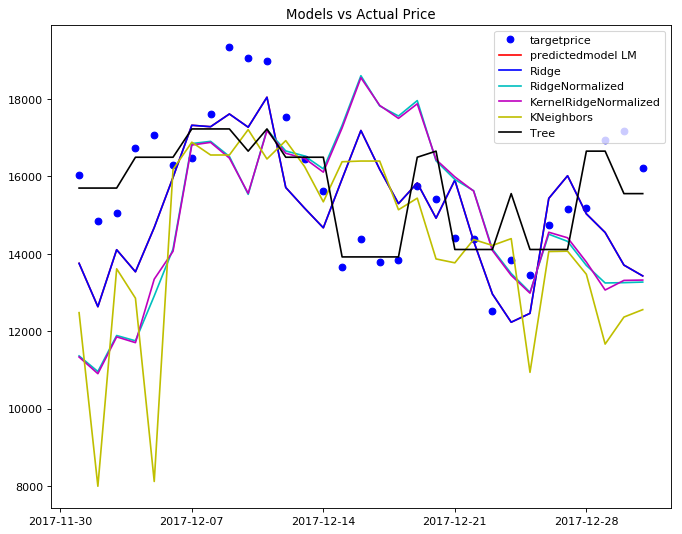

In [49]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

lineplot = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree']]
lineplot = lineplot.loc['2017-12-1':'2017-12-31']

plt.plot(lineplot.targetprice, 'bo')
plt.plot(lineplot['predictedmodel LM'], color='r')
plt.plot(lineplot.Ridge, color='b')
plt.plot(lineplot.RidgeNormalized, color='c')
plt.plot(lineplot.KernelRidgeNormalized, color='m')
plt.plot(lineplot.KNeighbors, color='y')
plt.plot(lineplot.Tree, color='k')

plt.legend(loc='upper right')
plt.title("Models vs Actual Price")
plt.show()


In [52]:
#RMSE for this time period
import math
from sklearn.metrics import mean_squared_error

LM = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['predictedmodel LM']))
Ridge = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Ridge']))
RidgeN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['RidgeNormalized']))
RidgeKerN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KernelRidgeNormalized']))
RidgeKNei = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KNeighbors']))
Tree = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Tree']))

print(LM)
print(Ridge)
print(RidgeN)
print(RidgeKerN)
print(RidgeKNei)
print(Tree)

1748.5564369193173
1748.595420339919
2745.641167673982
2729.129027778729
2993.2741781618315
1028.8340039178313


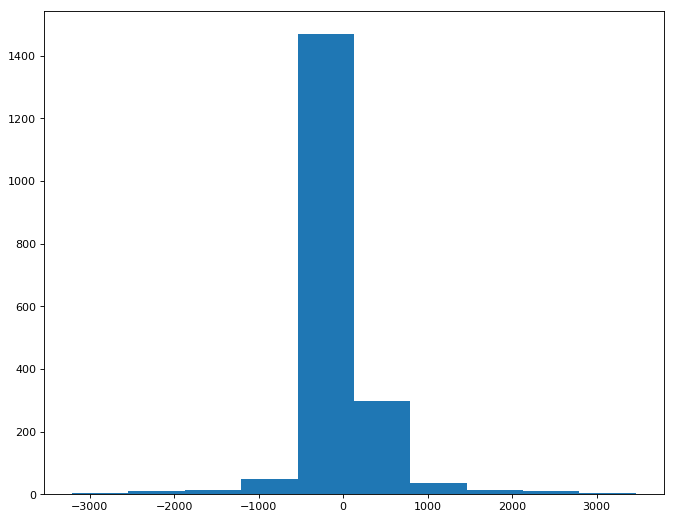

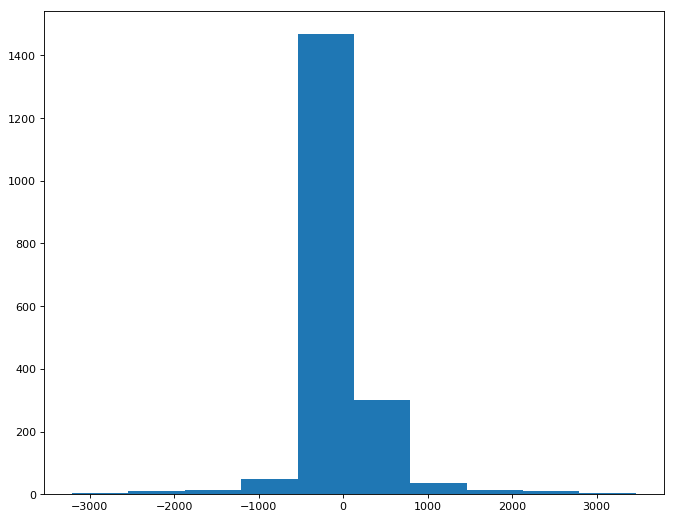

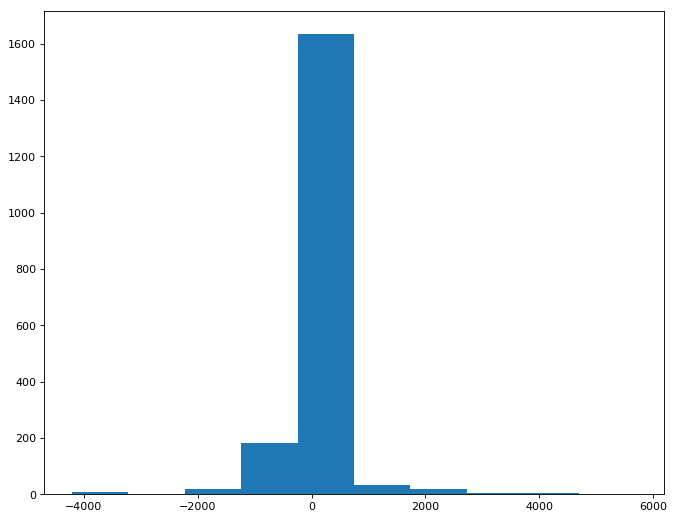

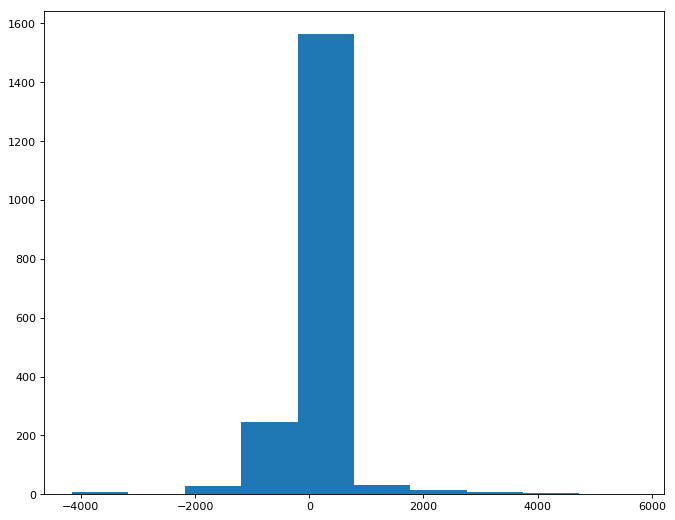

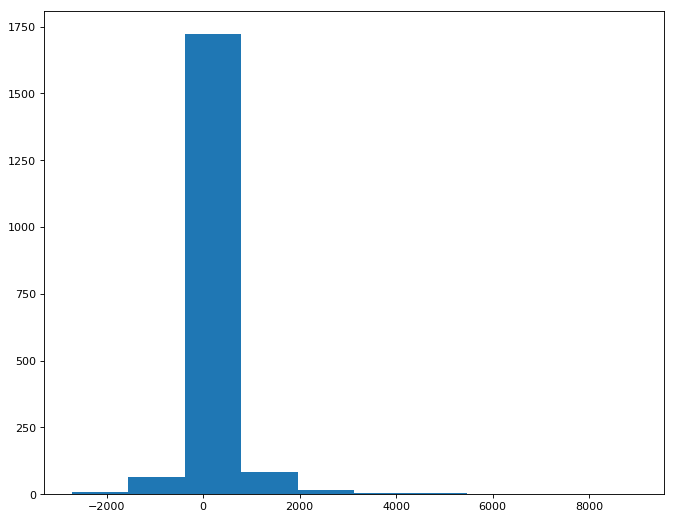

In [51]:
#Create residual Boxplots
LM_Residual = df3['targetprice'] - df3['predictedmodel LM']
Ridge_Residual = df3['targetprice'] - df3['Ridge']
RidgeN = df3['targetprice'] - df3['RidgeNormalized']
RidgeKerN = df3['targetprice'] - df3['KernelRidgeNormalized']
RidgeKNei = df3['targetprice'] - df3['KNeighbors']
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.hist(LM_Residual)
plt.show()
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(Ridge_Residual)
plt.show()
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(RidgeN)
plt.show()
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(RidgeKerN)
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.show()
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(RidgeKNei)
plt.show()
